In [2]:
import pandas as pd
import seaborn as sns
from datasets import load_dataset
from evaluation.loader import ResultLoader as loader
from evaluation.single_prediction_eval import SinglePredictionEvaluator
from models.model_runner import get_all_model_names, load_test_set
loader = loader()

In [3]:
gt = load_dataset("json", data_files="test_data.json", split="train")

In [4]:
data = loader.load('1000_basic')

INFO:root:loading dataset from: results/1000_basic/cerebras-6b7_original_1000.json


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:loading dataset from: results/1000_basic/bloomz-3b_paraphrased_1000.json


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:loading dataset from: results/1000_basic/cerebras-0b111_original_1000.json


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset json downloaded and prepared to /home/nya/.cache/huggingface/datasets/json/default-a55d8a7f596a4d52/0.0.0/a3e658c4731e59120d44081ac10bf85dc7e1388126b92338344ce9661907f253. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:loading dataset from: results/1000_basic/cerebras-2b7_paraphrased_1000.json


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:loading dataset from: results/1000_basic/bloomz-7b1_original_1000.json


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:loading dataset from: results/1000_basic/bloomz-3b_original_1000.json


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:loading dataset from: results/1000_basic/cerebras-0b111_paraphrased_1000.json


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset json downloaded and prepared to /home/nya/.cache/huggingface/datasets/json/default-5be1ccc812bf0df4/0.0.0/a3e658c4731e59120d44081ac10bf85dc7e1388126b92338344ce9661907f253. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:loading dataset from: results/1000_basic/bloomz-1b7_paraphrased_1000.json


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:loading dataset from: results/1000_basic/bloomz-7b1_paraphrased_1000.json


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:loading dataset from: results/1000_basic/cerebras-6b7_paraphrased_1000.json


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:loading dataset from: results/1000_basic/bloomz-1b7_original_1000.json


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:loading dataset from: results/1000_basic/cerebras-2b7_original_1000.json


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:loading dataset from: results/1000_basic/bloomz-1b1_original_1000.json


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:loading dataset from: results/1000_basic/cerebras-1b3_original_1000.json


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:loading dataset from: results/1000_basic/cerebras-1b3_paraphrased_1000.json


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:loading dataset from: results/1000_basic/bloomz-1b1_paraphrased_1000.json


  0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
import Levenshtein
import re
def compute_precision_for_page(page):
    distance = Levenshtein.distance(page["prediction"], page["title"], score_cutoff=15)
    regex = "|".join(['.*(' + nameFragment + ').*' for nameFragment in page["title"].split()])
    if re.match(regex, page["prediction"]):
        return { "correct": 1, "prediction": page["prediction"], "title": page["title"], "distance": distance }
    else:
        return { "correct": 0, "prediction": page["prediction"], "title": page["title"], "distance": distance }

In [22]:
results = {}
# no_mask_page_ids = set()
no_mask_original = gt.filter(lambda x: '<mask>' not in x['masked_text_original'][:1000])
no_mask_paraphrased = gt.filter(lambda x: '<mask>' not in x['masked_text_paraphrased'][:1000])
no_mask_page_ids = set(no_mask_original['id'] + no_mask_paraphrased['id'])
for key, models in data.items():
    for model_name, model in models.items():
        for config in ['original', 'paraphrased']:
            dataset = model[config]['train']
            ## add ground truth label to each prediction
            mappable = dataset.add_column("title", gt["title"])
            # filter out examples which did not include a mask
            
            # compute precision
            computed = mappable.map(compute_precision_for_page, num_proc=4, remove_columns=mappable.column_names)
            # compute metrics over computed results
            correct_predictions = computed.filter(lambda x: x['correct'] == 1)
            incorrect_predictions = computed.filter(lambda x: x['correct'] == 0)
            correct = len(correct_predictions)
            model[config]["result"] = {}
            model[config]["result"]["data"] = computed
            model[config]["result"]["accuracy"] = correct / len(dataset)
            model[config]["result"]["correct_predictions"] = correct_predictions
            model[config]["result"]["incorrect_predictions"] = incorrect_predictions

In [16]:
data

{'cerebras': {'6b7': {'size': 6.7,
   'inputsize': '1000',
   'original': DatasetDict({
       train: Dataset({
           features: ['prediction', 'page_id', 'input_length'],
           num_rows: 10000
       })
       result: {'data': Dataset({
           features: ['prediction', 'title', 'correct', 'distance'],
           num_rows: 10000
       }), 'accuracy': 0.0014, 'correct_predictions': Dataset({
           features: ['prediction', 'title', 'correct', 'distance'],
           num_rows: 14
       }), 'incorrect_predictions': Dataset({
           features: ['prediction', 'title', 'correct', 'distance'],
           num_rows: 9986
       })}
   }),
   'paraphrased': DatasetDict({
       train: Dataset({
           features: ['prediction', 'page_id', 'input_length'],
           num_rows: 10000
       })
       result: {'data': Dataset({
           features: ['prediction', 'title', 'correct', 'distance'],
           num_rows: 10000
       }), 'accuracy': 0.0002, 'correct_predictions': 

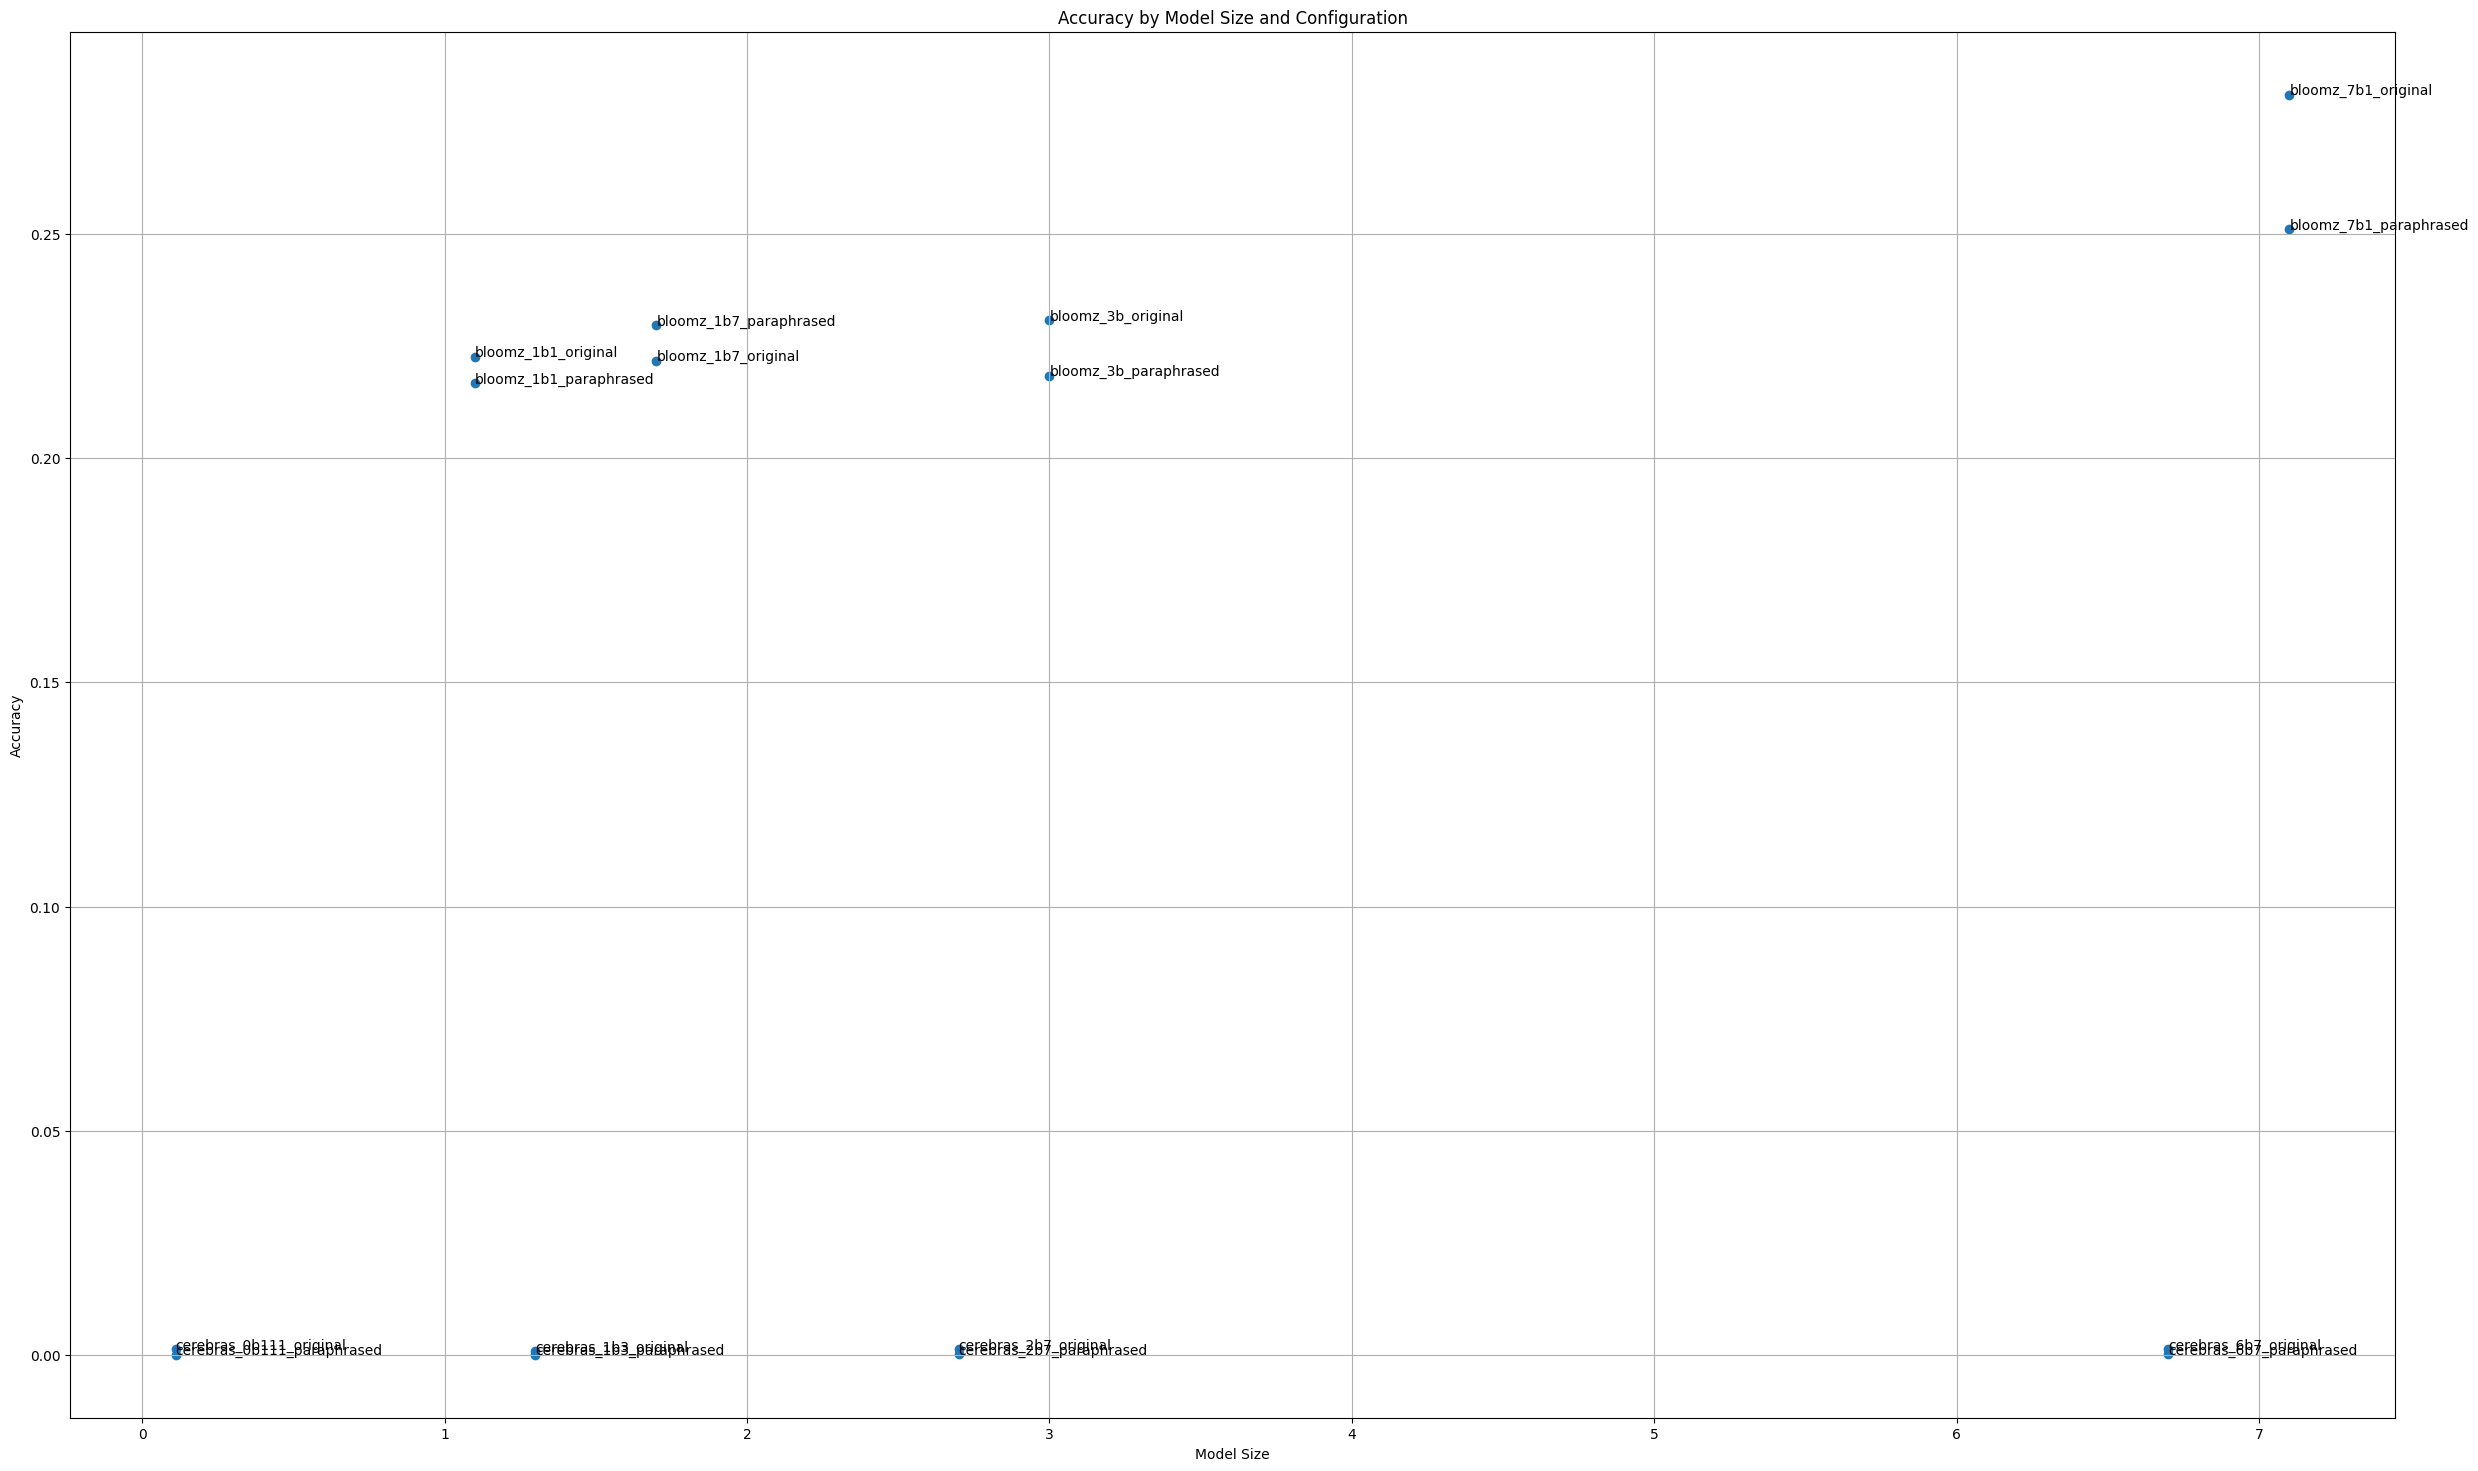

In [23]:
import matplotlib.pyplot as plt

# assuming your dataset is saved in a variable called 'data'
# data = {...}

sizes = []
accuracies = []
labels = []

for model, configs in data.items():
    for config, details in configs.items():
        for dataset, results in details.items():
            if isinstance(results, dict):  # check if result is a dictionary
                size = details['size']
                accuracy = results['result']['accuracy']
                
                sizes.append(size)
                accuracies.append(accuracy)
                labels.append(f"{model}_{config}_{dataset}")

plt.figure(figsize=(30, 18))
plt.scatter(sizes, accuracies)

for i, label in enumerate(labels):
    plt.annotate(label, (sizes[i], accuracies[i]))

plt.xlabel('Model Size')
plt.ylabel('Accuracy')
plt.title('Accuracy by Model Size and Configuration')
plt.grid(True)
plt.show()

In [12]:
### check if all examples actually had a mask. should not count any examples which did not
no_mask_original = gt.filter(lambda x: '<mask>' not in x['masked_text_original'][:1000])
no_mask_paraphrased = gt.filter(lambda x: '<mask>' not in x['masked_text_paraphrased'][:1000])
print(len(no_mask_original))
print(len(no_mask_paraphrased))

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

63
500


In [18]:
data['cerebras']['6b7']['original']

DatasetDict({
    train: Dataset({
        features: ['prediction', 'page_id', 'input_length'],
        num_rows: 10000
    })
    result: {'data': Dataset({
        features: ['prediction', 'title', 'correct', 'distance'],
        num_rows: 10000
    }), 'accuracy': 0.0014, 'correct_predictions': Dataset({
        features: ['prediction', 'title', 'correct', 'distance'],
        num_rows: 14
    }), 'incorrect_predictions': Dataset({
        features: ['prediction', 'title', 'correct', 'distance'],
        num_rows: 9986
    })}
})